# Parametry

In [1]:
# Ścieżka do folderu z danymi
folder_path = 'C:/Users/oliwi/OneDrive/Pulpit/2023_dane_praca_magisterska.xlsx'

# Nazwy dla tabel wynikowych
missing_values_excel_name = 'missing_val.xlsx'
sheet_name = ''
stats_output_file = 'stats.xlsx'

# Import bibliotek

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from linearmodels import PanelOLS
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


# Przygotowanie danych

Załadowanie danych z podanej ścieżki

In [3]:
loaded_data = pd.read_excel(folder_path)

In [4]:
len(loaded_data)

832

In [5]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Country                                           832 non-null    object 
 1   Year                                              832 non-null    int64  
 2   Human Development Index (HDI)                     822 non-null    float64
 3   Life expectancy at birth                          832 non-null    float64
 4   Expected years of schooling                       832 non-null    float64
 5   Mean years of schooling                           832 non-null    float64
 6   Gross national income (GNI) per capita            822 non-null    float64
 7   CO2 emissions (metric tons per capita)            806 non-null    float64
 8   GDP per capita, PPP (current international $)     804 non-null    float64
 9   Labor force, total   

In [6]:
loaded_data['Country'].unique().tolist()

['Belgium',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden']

Weryfikacja wartości brakujących

In [7]:
def check_missing_values(df: pd.DataFrame) -> None:
        
        '''Method responsible for checking missing values in data frame,
        method prepare data frame with country and year of missing vlues
        Args:
        df: input data

        Method returns pandas Data Frame with missing values'''

        result = []

        for i in range(len(df)):
            for col in df.columns:
                if pd.isnull(df.loc[i, col]):   
                    result.append({
                    'Column': col,
                    'Country': df.loc[i, 'Country'],
                    'Year': df.loc[i, 'Year']
                })

        result = pd.DataFrame(result)
        result = result.to_excel(missing_values_excel_name)

        return None

In [8]:
check_missing_values(loaded_data)

Ograniczenie danych od roku 1995 - 2020

In [9]:
filtered_loaded_data = loaded_data[(loaded_data['Year'] >= 1995) & (loaded_data['Year'] <= 2020)]

In [10]:
filtered_loaded_data['Unemployment'] = filtered_loaded_data['Unemployment, total (% of total labor force) ']
filtered_loaded_data.drop('Unemployment, total (% of total labor force) ', axis=1, inplace=True)

C:\Users\oliwi\AppData\Local\Temp\ipykernel_17020\1633989283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loaded_data['Unemployment'] = filtered_loaded_data['Unemployment, total (% of total labor force) ']
C:\Users\oliwi\AppData\Local\Temp\ipykernel_17020\1633989283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loaded_data.drop('Unemployment, total (% of total labor force) ', axis=1, inplace=True)


# Przygotowanie statystyk opisowych

In [11]:
stats_df = filtered_loaded_data.copy()

In [12]:
stats_df.describe().round(2)

,Year,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)",Net migration,Unemployment
count,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.00,676.0,676.00,674.00
mean,2007.50,0.85,77.62,15.65,11.11,34829.29,7.88,29951.28,7807372.86,5.18,3.5,32334.23,9.01
std,7.51,0.06,3.49,1.83,1.58,14805.28,3.52,17308.82,10261727.99,3.11,2.1,102272.74,4.49
min,1995.00,0.69,67.02,10.42,6.13,9057.38,2.97,5429.42,147591.00,1.70,0.9,-254292.00,1.80
25%,2001.00,0.81,75.18,14.49,10.15,24315.67,5.52,19204.37,1513684.00,3.30,2.3,-2667.50,5.90
50%,2007.50,0.86,78.12,15.74,11.32,32516.01,7.26,27658.27,3886304.00,4.20,2.9,8014.50,7.90
75%,2014.00,0.90,80.53,16.73,12.31,43796.36,9.68,37300.87,8713744.50,6.00,4.1,31251.75,11.17
max,2020.00,0.95,83.59,20.03,14.13,93173.95,25.61,120010.21,44433744.00,22.10,15.6,774489.00,32.61


Funkcja tworząca wykresy pudełkowe

In [13]:
def create_box_plot(df: pd.DataFrame, col_name: str, title: str) -> None:

    mean= df[col_name].mean()
    df['Difference from Mean'] = df[col_name] - mean 
    plt.figure(figsize=(10, 6))
    plt.boxplot(stats_df['Difference from Mean'])
    plt.xlabel('Różnica od średniej')
    plt.title(title)
    plt.ylabel(f'{col_name}')
    plt.grid(True)
    plt.show()

    return None

Wykres pudełkowy dla zmiennej Human Development Index

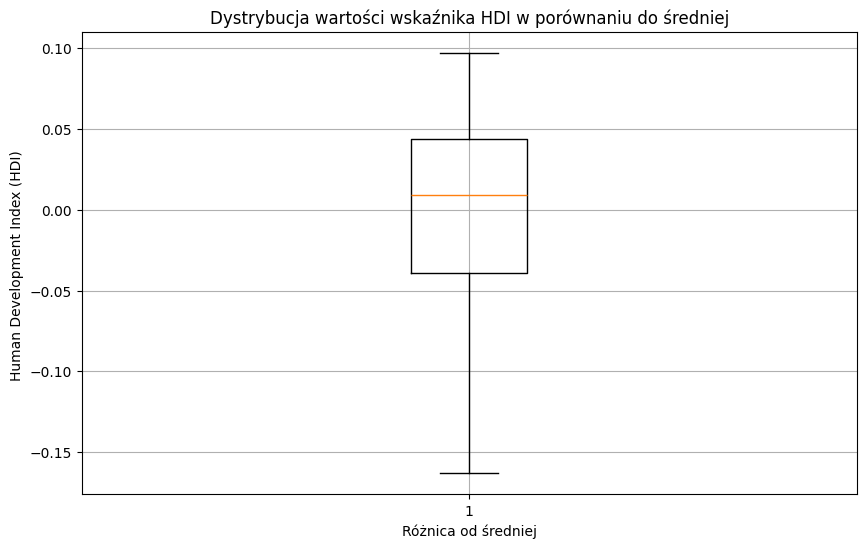

In [14]:
create_box_plot(stats_df,'Human Development Index (HDI) ', 'Dystrybucja wartości wskaźnika HDI w porównaniu do średniej')

Wykres pudełkowy dla zmiennej oczekiwana długość życia w momencie urodzenia

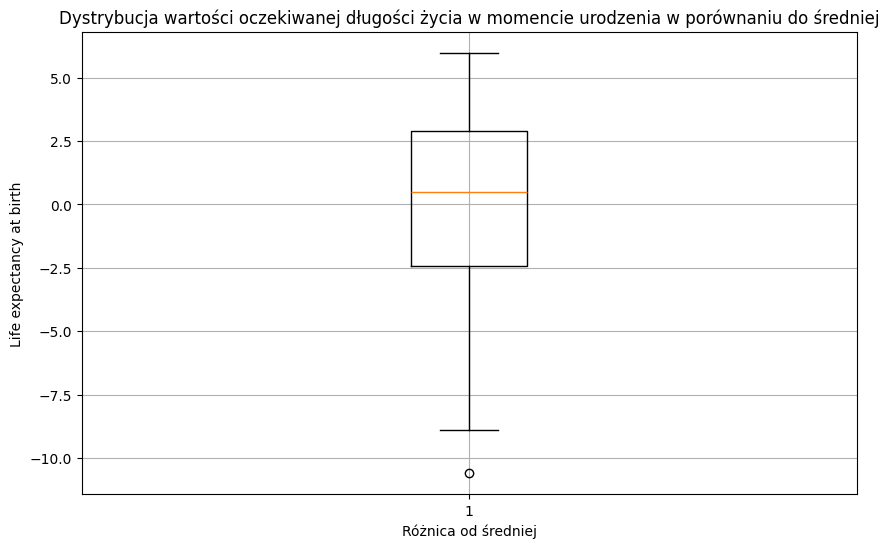

In [15]:
create_box_plot(stats_df,'Life expectancy at birth', 'Dystrybucja wartości oczekiwanej długości życia w momencie urodzenia w porównaniu do średniej')

Funkcja odpowiadająca za obliczanie z-score

In [16]:
def z_score_calc(df: pd.DataFrame, col_name: str, max_score_row_numbers: int) -> None:
    df[f'Z-Score_{col_name}'] = (df[col_name] - df[col_name].mean()) / df[col_name].std()
    max_z_score_row = df[['Country','Year',col_name,f'Z-Score_{col_name}']].nlargest(max_score_row_numbers, f'Z-Score_{col_name}')
    print(max_z_score_row)

    return None

In [17]:
z_score_calc(stats_df, 'Life expectancy at birth', 3)

     Country  Year  Life expectancy at birth  Z-Score_Life expectancy at birth
571    Malta  2017                   83.5867                          1.710394
413  Ireland  2019                   83.5520                          1.700445
797    Spain  2019                   83.5321                          1.694740


Wykres pudełkowy dla zmiennej oczekiwana liczba lat nauki

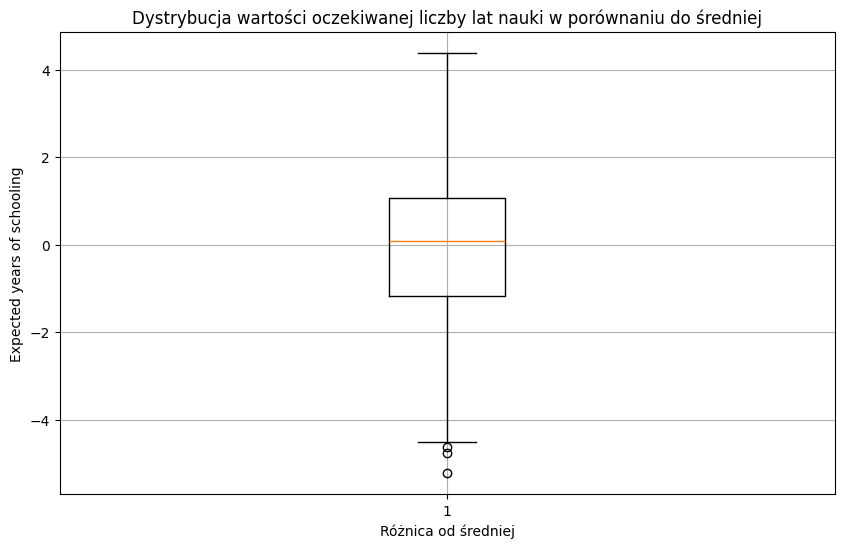

In [18]:
create_box_plot(stats_df,'Expected years of schooling', 'Dystrybucja wartości oczekiwanej liczby lat nauki w porównaniu do średniej')

In [19]:
z_score_calc(stats_df,'Expected years of schooling', 3)

     Country  Year  Expected years of schooling  \
349   Greece  2019                     20.02879   
350   Greece  2020                     20.02879   
27   Belgium  2017                     19.77438   

     Z-Score_Expected years of schooling  
349                             2.398560  
350                             2.398560  
27                              2.259179  


Wykres pudełkowy dla zmiennej średnia liczba lat nauki

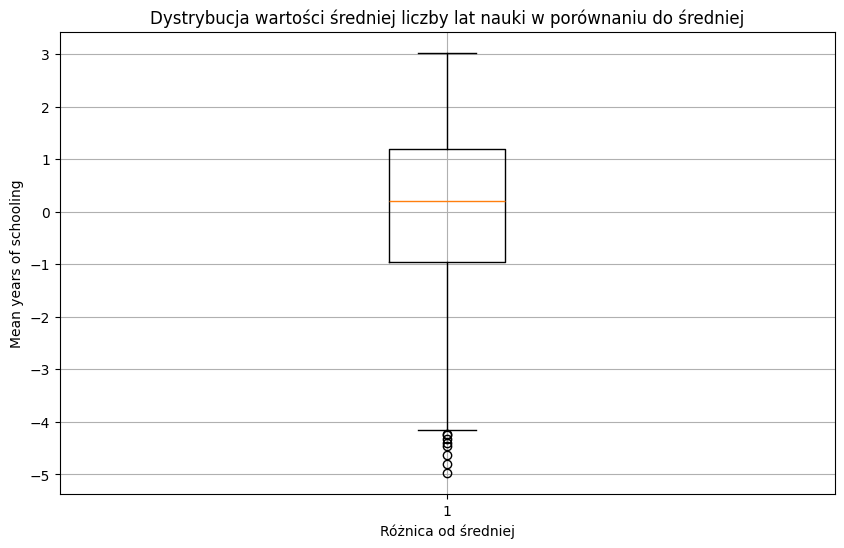

In [20]:
create_box_plot(stats_df, 'Mean years of schooling', 'Dystrybucja wartości średniej liczby lat nauki w porównaniu do średniej')

In [21]:
z_score_calc(stats_df, 'Mean years of schooling', 7)

     Country  Year  Mean years of schooling  Z-Score_Mean years of schooling
313  Germany  2016                14.132150                         1.916512
315  Germany  2017                14.104765                         1.899138
317  Germany  2019                14.090967                         1.890384
318  Germany  2020                14.090967                         1.890384
312  Germany  2015                14.082020                         1.884708
316  Germany  2018                14.077380                         1.881764
311  Germany  2014                14.037120                         1.856222


Wykres pudełkowy dla zmiennej GNI per capita

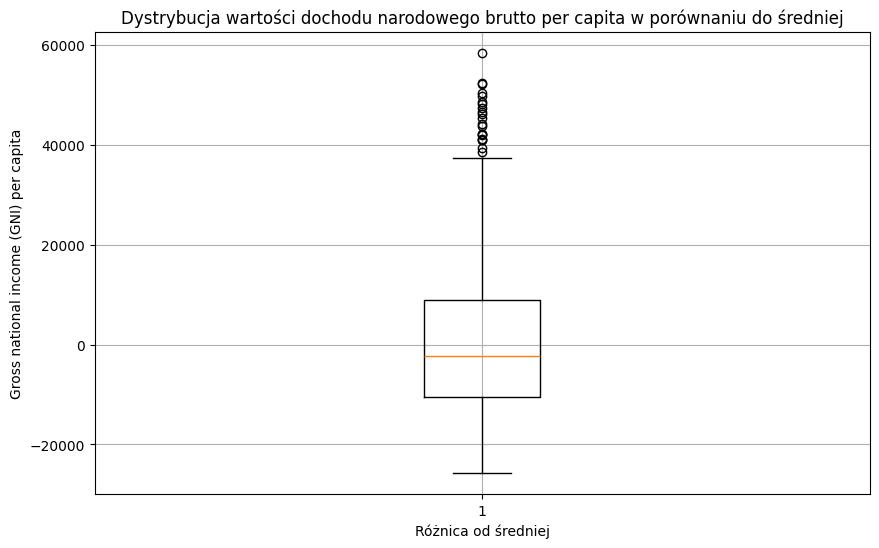

In [22]:
create_box_plot(stats_df, 'Gross national income (GNI) per capita', 'Dystrybucja wartości dochodu narodowego brutto per capita w porównaniu do średniej')

In [23]:
z_score_calc(stats_df, 'Gross national income (GNI) per capita', 10)

        Country  Year  Gross national income (GNI) per capita  \
520  Luxembourg  2007                             93173.94869   
522  Luxembourg  2008                             87146.29368   
517  Luxembourg  2005                             87012.00638   
530  Luxembourg  2012                             85299.29025   
518  Luxembourg  2004                             84564.32485   
536  Luxembourg  2014                             83495.10830   
519  Luxembourg  2006                             82926.69144   
541  Luxembourg  2017                             82296.95125   
538  Luxembourg  2018                             81398.52451   
533  Luxembourg  2013                             80965.91409   

     Z-Score_Gross national income (GNI) per capita  
520                                        3.940802  
522                                        3.533673  
517                                        3.524603  
530                                        3.408920  
518           

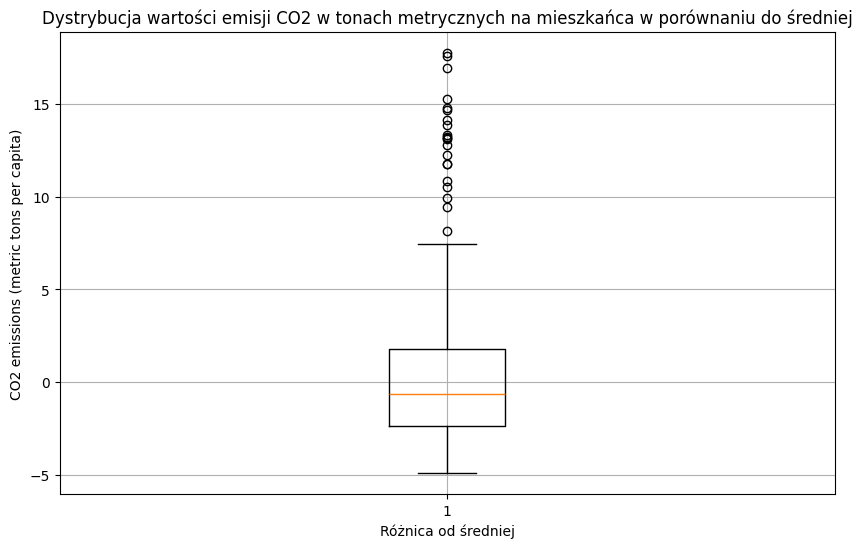

In [24]:
create_box_plot(stats_df, 'CO2 emissions (metric tons per capita)', 'Dystrybucja wartości emisji CO2 w tonach metrycznych na mieszkańca w porównaniu do średniej')

In [25]:
z_score_calc(stats_df, 'CO2 emissions (metric tons per capita)', 20)

        Country  Year  CO2 emissions (metric tons per capita)  \
517  Luxembourg  2005                               25.610438   
518  Luxembourg  2004                               25.452799   
519  Luxembourg  2006                               24.791119   
520  Luxembourg  2007                               23.155338   
521  Luxembourg  2003                               22.676970   
522  Luxembourg  2008                               22.557045   
523  Luxembourg  2002                               22.005491   
524  Luxembourg  2010                               21.755666   
525  Luxembourg  1995                               21.192781   
526  Luxembourg  1996                               21.091919   
527  Luxembourg  2011                               21.041503   
528  Luxembourg  2009                               20.978820   
529  Luxembourg  2001                               20.652285   
530  Luxembourg  2012                               20.148942   
531  Luxembourg  1997    

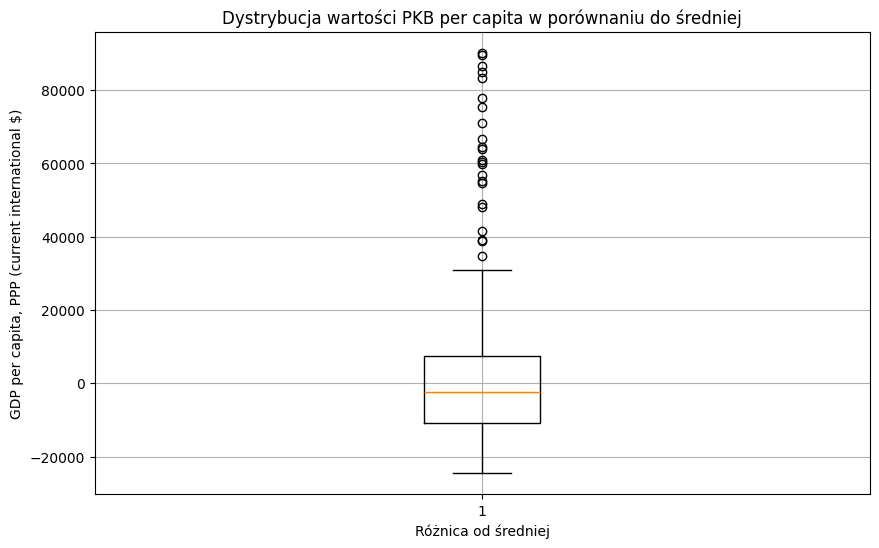

In [26]:
create_box_plot(stats_df, 'GDP per capita, PPP (current international $)', 'Dystrybucja wartości PKB per capita w porównaniu do średniej')

In [27]:
z_score_calc(stats_df, 'GDP per capita, PPP (current international $)', 10)

        Country  Year  GDP per capita, PPP (current international $)  \
542  Luxembourg  2020                                  120010.208308   
539  Luxembourg  2019                                  119541.758444   
538  Luxembourg  2018                                  116498.512081   
541  Luxembourg  2017                                  114985.842236   
540  Luxembourg  2016                                  113365.176082   
537  Luxembourg  2015                                  107859.685999   
536  Luxembourg  2014                                  105296.284588   
533  Luxembourg  2013                                  100925.011992   
530  Luxembourg  2012                                   96636.426644   
527  Luxembourg  2011                                   94475.030227   

     Z-Score_GDP per capita, PPP (current international $)  
542                                           5.203065      
539                                           5.176001      
538                     

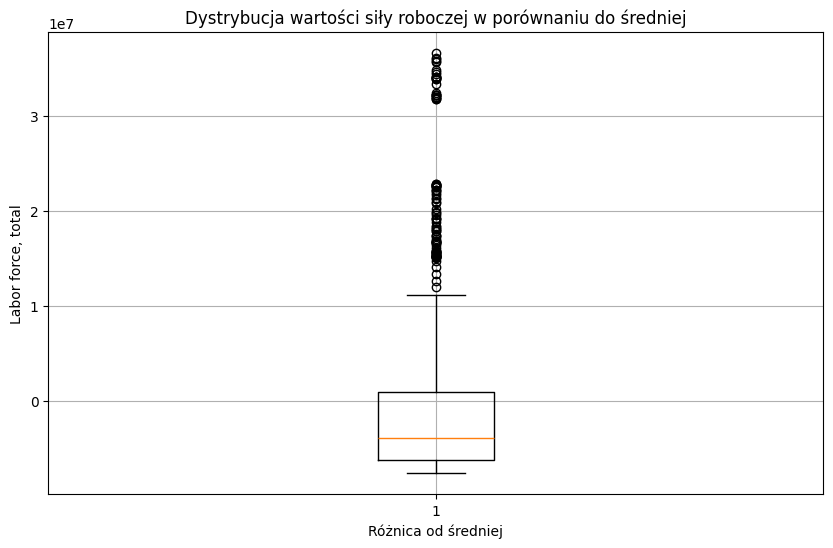

In [28]:
create_box_plot(stats_df, 'Labor force, total', 'Dystrybucja wartości siły roboczej w porównaniu do średniej')

In [29]:
z_score_calc(stats_df, 'Labor force, total', 20)

     Country  Year  Labor force, total  Z-Score_Labor force, total
317  Germany  2019          44433744.0                    3.569221
316  Germany  2018          43935038.0                    3.520622
315  Germany  2017          43819028.0                    3.509317
314  Germany  2009          43567225.0                    3.484779
318  Germany  2020          43501190.0                    3.478344
313  Germany  2016          42660629.0                    3.396431
312  Germany  2015          42458390.0                    3.376723
311  Germany  2014          42212988.0                    3.352809
307  Germany  2007          41978630.0                    3.329971
308  Germany  2010          41949335.0                    3.327116
306  Germany  2008          41917490.0                    3.324013
305  Germany  2013          41861246.0                    3.318532
310  Germany  2011          41853628.0                    3.317790
309  Germany  2012          41729225.0                    3.30

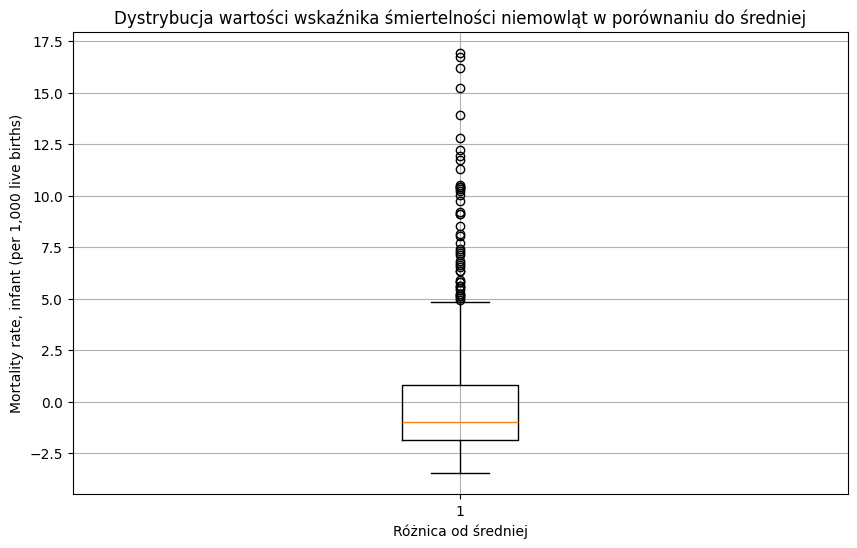

In [30]:
create_box_plot(stats_df, 'Mortality rate, infant (per 1,000 live births)', 'Dystrybucja wartości wskaźnika śmiertelności niemowląt w porównaniu do średniej')

In [31]:
z_score_calc(stats_df, 'Mortality rate, infant (per 1,000 live births)', 10)

     Country  Year  Mortality rate, infant (per 1,000 live births)  \
676  Romania  1995                                            22.1   
675  Romania  1996                                            21.9   
679  Romania  1997                                            21.4   
686  Romania  1998                                            20.4   
697  Romania  1999                                            19.1   
691  Romania  2000                                            18.0   
688  Romania  2001                                            17.4   
687  Romania  2002                                            17.1   
683  Romania  2003                                            16.9   
684  Romania  2004                                            16.5   

     Z-Score_Mortality rate, infant (per 1,000 live births)  
676                                           5.442539       
675                                           5.378209       
679                                        

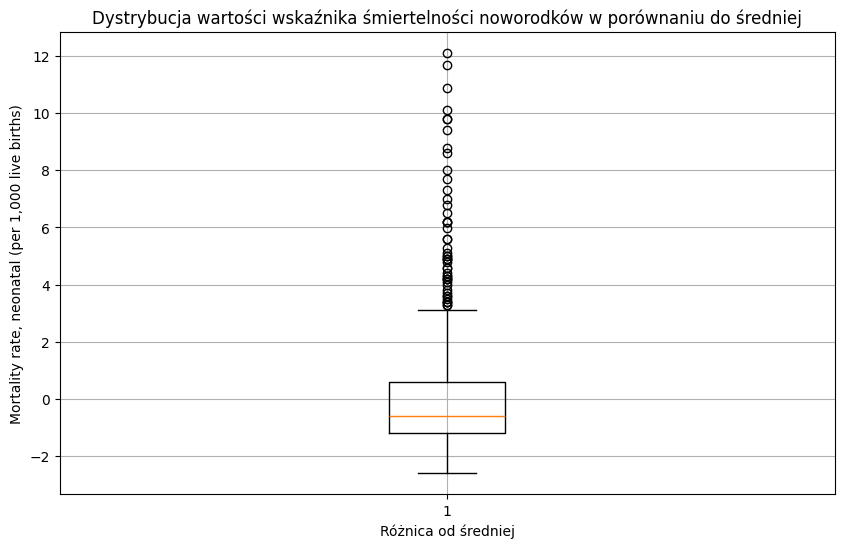

In [32]:
create_box_plot(stats_df, 'Mortality rate, neonatal (per 1,000 live births)', 'Dystrybucja wartości wskaźnika śmiertelności noworodków w porównaniu do średniej')

In [33]:
z_score_calc(stats_df, 'Mortality rate, neonatal (per 1,000 live births)', 10)

     Country  Year  Mortality rate, neonatal (per 1,000 live births)  \
453   Latvia  1995                                              15.6   
454   Latvia  1996                                              15.2   
455   Latvia  1997                                              14.4   
676  Romania  1995                                              13.6   
456   Latvia  1998                                              13.3   
675  Romania  1996                                              13.3   
679  Romania  1997                                              12.9   
457   Latvia  1999                                              12.3   
686  Romania  1998                                              12.1   
458   Latvia  2000                                              11.5   

     Z-Score_Mortality rate, neonatal (per 1,000 live births)  
453                                           5.757370         
454                                           5.566988         
455            

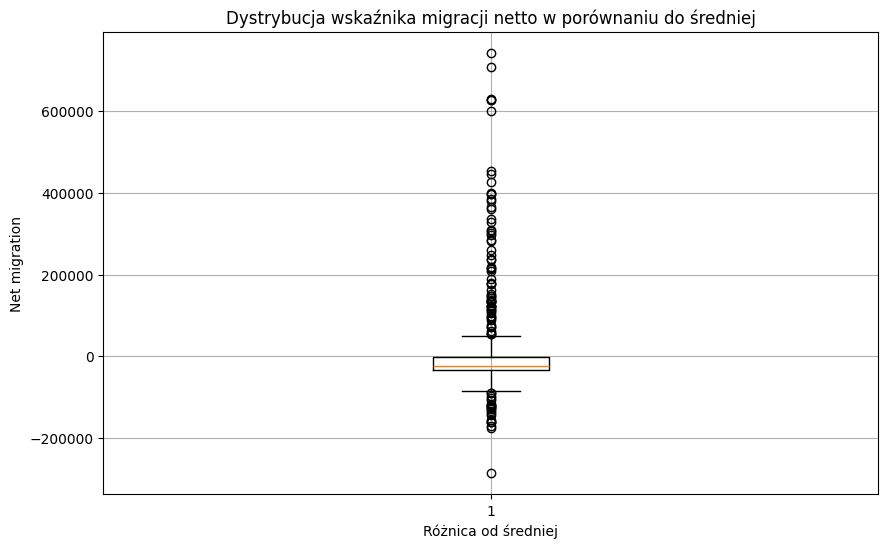

In [34]:
create_box_plot(stats_df, 'Net migration', 'Dystrybucja wskaźnika migracji netto w porównaniu do średniej')

In [35]:
z_score_calc(stats_df, 'Net migration', 15)

     Country  Year  Net migration  Z-Score_Net migration
785    Spain  2007       774489.0               7.256624
780    Spain  2002       741349.0               6.932588
781    Spain  2003       662840.0               6.164945
782    Spain  2004       661105.0               6.147980
784    Spain  2006       658689.0               6.124357
783    Spain  2005       632974.0               5.872922
420    Italy  2007       485871.0               4.434581
418    Italy  2003       478254.0               4.360104
797    Spain  2019       458942.0               4.171276
313  Germany  2016       432017.0               3.908009
315  Germany  2017       430803.0               3.896139
786    Spain  2008       430778.0               3.895894
416    Italy  2004       417189.0               3.763024
425    Italy  2008       413349.0               3.725477
312  Germany  2015       397921.0               3.574626


In [36]:
z_score_calc(stats_df, 'Unemployment',5)

      Country  Year  Unemployment  Z-Score_Unemployment
55   Bulgaria  2001        32.610              5.254106
343    Greece  2013        27.686              4.157783
344    Greece  2014        26.708              3.940032
791     Spain  2013        26.094              3.803326
345    Greece  2015        24.981              3.555517


In [37]:
data_dropped_year = filtered_loaded_data.drop(['Year'], axis=1)

In [38]:
stats_groupped_per_country = data_dropped_year.groupby('Country').describe()

In [39]:
stats_groupped_per_country.to_excel(stats_output_file)

# Przygotowanie macierzy korelacji

In [40]:
data_dropped_year

,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)",Net migration,Unemployment
0,Belgium,0.871,77.1825,17.590561,10.196610,40705.62742,11.760625,22744.699662,4205314.0,5.9,3.6,19272.0,9.483
1,Belgium,0.878,77.4743,17.687514,10.370275,42943.50772,11.703686,24369.486718,4269462.0,5.2,3.3,25295.0,9.323
2,Belgium,0.890,78.0807,18.383110,10.641110,45220.35759,11.504301,28793.611054,4315763.0,4.7,2.9,35439.0,6.178
3,Belgium,0.876,77.4004,17.639037,10.283443,42112.15687,11.455839,23732.221071,4229113.0,5.5,3.5,22141.0,8.950
4,Belgium,0.887,77.7665,17.924540,10.543940,45184.55302,11.440029,27789.943546,4416525.0,4.8,3.0,32262.0,6.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,Sweden,0.939,82.3391,18.832430,12.413600,51813.28127,3.899110,50430.252820,5244040.0,2.3,1.6,79667.0,6.990
827,Sweden,0.941,82.4382,19.482340,12.486050,52849.39299,3.794924,51947.954248,5331161.0,2.3,1.5,80765.0,6.718
828,Sweden,0.942,82.5326,19.691019,12.547885,53050.91638,3.529744,53521.630643,5396547.0,2.2,1.5,81492.0,6.365
829,Sweden,0.947,83.0524,19.418530,12.609720,54222.71686,3.401594,56404.300204,5456623.0,2.1,1.4,81585.0,6.833


In [41]:
dropped_country_and_year = data_dropped_year.drop(['Country'], axis = 1)

In [42]:
dropped_country_and_year.corr()

,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)",Net migration,Unemployment
Human Development Index (HDI),1.000000,0.822677,0.803663,0.585070,0.790180,0.209468,0.747806,0.225250,-0.825275,-0.777659,0.281327,-0.279367
Life expectancy at birth,0.822677,1.000000,0.603362,0.119680,0.719133,0.051323,0.710013,0.234945,-0.783837,-0.753747,0.317693,-0.150653
Expected years of schooling,0.803663,0.603362,1.000000,0.386663,0.442528,-0.057970,0.385880,0.162162,-0.620106,-0.580138,0.222603,-0.040532
Mean years of schooling,0.585070,0.119680,0.386663,1.000000,0.298258,0.214361,0.389448,0.056205,-0.350255,-0.302287,-0.012536,-0.217340
Gross national income (GNI) per capita,0.790180,0.719133,0.442528,0.298258,1.000000,0.513098,0.861731,0.173215,-0.639110,-0.611607,0.275096,-0.398627
CO2 emissions (metric tons per capita),0.209468,0.051323,-0.057970,0.214361,0.513098,1.000000,0.380592,-0.106033,-0.186088,-0.133806,0.046731,-0.244180
"GDP per capita, PPP (current international $)",0.747806,0.710013,0.385880,0.389448,0.861731,0.380592,1.000000,0.052927,-0.611289,-0.580380,0.169936,-0.342817
"Labor force, total",0.225250,0.234945,0.162162,0.056205,0.173215,-0.106033,0.052927,1.000000,-0.106436,-0.120295,0.547816,0.085849
"Mortality rate, infant (per 1,000 live births)",-0.825275,-0.783837,-0.620106,-0.350255,-0.639110,-0.186088,-0.611289,-0.106436,1.000000,0.934994,-0.270604,0.163488
"Mortality rate, neonatal (per 1,000 live births)",-0.777659,-0.753747,-0.580138,-0.302287,-0.611607,-0.133806,-0.580380,-0.120295,0.934994,1.000000,-0.244352,0.187386


In [43]:
dropped_rate_neonatal = dropped_country_and_year.drop(['Mortality rate, neonatal (per 1,000 live births)'], axis=1)

In [44]:
dropped_rate_neonatal.corr()

,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)",Net migration,Unemployment
Human Development Index (HDI),1.000000,0.822677,0.803663,0.585070,0.790180,0.209468,0.747806,0.225250,-0.825275,0.281327,-0.279367
Life expectancy at birth,0.822677,1.000000,0.603362,0.119680,0.719133,0.051323,0.710013,0.234945,-0.783837,0.317693,-0.150653
Expected years of schooling,0.803663,0.603362,1.000000,0.386663,0.442528,-0.057970,0.385880,0.162162,-0.620106,0.222603,-0.040532
Mean years of schooling,0.585070,0.119680,0.386663,1.000000,0.298258,0.214361,0.389448,0.056205,-0.350255,-0.012536,-0.217340
Gross national income (GNI) per capita,0.790180,0.719133,0.442528,0.298258,1.000000,0.513098,0.861731,0.173215,-0.639110,0.275096,-0.398627
CO2 emissions (metric tons per capita),0.209468,0.051323,-0.057970,0.214361,0.513098,1.000000,0.380592,-0.106033,-0.186088,0.046731,-0.244180
"GDP per capita, PPP (current international $)",0.747806,0.710013,0.385880,0.389448,0.861731,0.380592,1.000000,0.052927,-0.611289,0.169936,-0.342817
"Labor force, total",0.225250,0.234945,0.162162,0.056205,0.173215,-0.106033,0.052927,1.000000,-0.106436,0.547816,0.085849
"Mortality rate, infant (per 1,000 live births)",-0.825275,-0.783837,-0.620106,-0.350255,-0.639110,-0.186088,-0.611289,-0.106436,1.000000,-0.270604,0.163488
Net migration,0.281327,0.317693,0.222603,-0.012536,0.275096,0.046731,0.169936,0.547816,-0.270604,1.000000,-0.073724


In [45]:
dropped_gni = dropped_rate_neonatal.drop(['Gross national income (GNI) per capita'], axis=1)

In [46]:
dropped_gni.corr()

,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)",Net migration,Unemployment
Human Development Index (HDI),1.000000,0.822677,0.803663,0.585070,0.209468,0.747806,0.225250,-0.825275,0.281327,-0.279367
Life expectancy at birth,0.822677,1.000000,0.603362,0.119680,0.051323,0.710013,0.234945,-0.783837,0.317693,-0.150653
Expected years of schooling,0.803663,0.603362,1.000000,0.386663,-0.057970,0.385880,0.162162,-0.620106,0.222603,-0.040532
Mean years of schooling,0.585070,0.119680,0.386663,1.000000,0.214361,0.389448,0.056205,-0.350255,-0.012536,-0.217340
CO2 emissions (metric tons per capita),0.209468,0.051323,-0.057970,0.214361,1.000000,0.380592,-0.106033,-0.186088,0.046731,-0.244180
"GDP per capita, PPP (current international $)",0.747806,0.710013,0.385880,0.389448,0.380592,1.000000,0.052927,-0.611289,0.169936,-0.342817
"Labor force, total",0.225250,0.234945,0.162162,0.056205,-0.106033,0.052927,1.000000,-0.106436,0.547816,0.085849
"Mortality rate, infant (per 1,000 live births)",-0.825275,-0.783837,-0.620106,-0.350255,-0.186088,-0.611289,-0.106436,1.000000,-0.270604,0.163488
Net migration,0.281327,0.317693,0.222603,-0.012536,0.046731,0.169936,0.547816,-0.270604,1.000000,-0.073724
Unemployment,-0.279367,-0.150653,-0.040532,-0.217340,-0.244180,-0.342817,0.085849,0.163488,-0.073724,1.000000


In [47]:
dropped_hdi = dropped_gni.drop(['Human Development Index (HDI) '], axis=1)

In [48]:
dropped_hdi.corr()

,Life expectancy at birth,Expected years of schooling,Mean years of schooling,CO2 emissions (metric tons per capita),"GDP per capita, PPP (current international $)","Labor force, total","Mortality rate, infant (per 1,000 live births)",Net migration,Unemployment
Life expectancy at birth,1.000000,0.603362,0.119680,0.051323,0.710013,0.234945,-0.783837,0.317693,-0.150653
Expected years of schooling,0.603362,1.000000,0.386663,-0.057970,0.385880,0.162162,-0.620106,0.222603,-0.040532
Mean years of schooling,0.119680,0.386663,1.000000,0.214361,0.389448,0.056205,-0.350255,-0.012536,-0.217340
CO2 emissions (metric tons per capita),0.051323,-0.057970,0.214361,1.000000,0.380592,-0.106033,-0.186088,0.046731,-0.244180
"GDP per capita, PPP (current international $)",0.710013,0.385880,0.389448,0.380592,1.000000,0.052927,-0.611289,0.169936,-0.342817
"Labor force, total",0.234945,0.162162,0.056205,-0.106033,0.052927,1.000000,-0.106436,0.547816,0.085849
"Mortality rate, infant (per 1,000 live births)",-0.783837,-0.620106,-0.350255,-0.186088,-0.611289,-0.106436,1.000000,-0.270604,0.163488
Net migration,0.317693,0.222603,-0.012536,0.046731,0.169936,0.547816,-0.270604,1.000000,-0.073724
Unemployment,-0.150653,-0.040532,-0.217340,-0.244180,-0.342817,0.085849,0.163488,-0.073724,1.000000


Uzupełnienie braków danych w kolumnie bezrobocie medianą

In [49]:
median_unemployment = dropped_hdi['Unemployment'].median()

In [84]:
filtered_loaded_data['Unemployment'] = filtered_loaded_data['Unemployment'].fillna(median_unemployment)

C:\Users\oliwi\AppData\Local\Temp\ipykernel_17020\3415279394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loaded_data['Unemployment'] = filtered_loaded_data['Unemployment'].fillna(median_unemployment)


In [91]:
prepared_data = filtered_loaded_data.drop([
    'Mortality rate, neonatal (per 1,000 live births)',
    'Gross national income (GNI) per capita',
    'Human Development Index (HDI) '], axis = 1)

In [92]:
prepared_data.set_index(['Country', 'Year'], inplace=True)

In [93]:
prepared_data

Life expectancy at birth  Expected years of schooling  \
Country Year                                                          
Belgium 1996                   77.1825                    17.590561   
        1998                   77.4743                    17.687514   
        2001                   78.0807                    18.383110   
        1997                   77.4004                    17.639037   
        2000                   77.7665                    17.924540   
...                                ...                          ...   
Sweden  2016                   82.3391                    18.832430   
        2017                   82.4382                    19.482340   
        2018                   82.5326                    19.691019   
        2019                   83.0524                    19.418530   
        2020                   82.4274                    19.418530   

              Mean years of schooling  CO2 emissions (metric tons per capita)  \
Country Year                                                                    
Belgium 1996                10.196610                               11.760625   
        1998                10.370275                               11.703686   
        2001                10.641110                               11.504301   
        1997                10.283443                               11.455839   
        2000                10.543940                               11.440029   
...                               ...                                     ...   
Sweden  2016                12.413600                                3.899110   
        2017                12.486050                                3.794924   
        2018                12.547885                                3.529744   
        2019                12.609720                                3.401594   
        2020                12.609720                                3.242989   

              GDP per capita, PPP (current international $)  \
Country Year                                                  
Belgium 1996                                   22744.699662   
        1998                                   24369.486718   
        2001                                   28793.611054   
        1997                                   23732.221071   
        2000                                   27789.943546   
...                                                     ...   
Sweden  2016                                   50430.252820   
        2017                                   51947.954248   
        2018                                   53521.630643   
        2019                                   56404.300204   
        2020                                   56140.552395   

              Labor force, total  \
Country Year                       
Belgium 1996           4205314.0   
        1998           4269462.0   
        2001           4315763.0   
        1997           4229113.0   
        2000           4416525.0   
...                          ...   
Sweden  2016           5244040.0   
        2017           5331161.0   
        2018           5396547.0   
        2019           5456623.0   
        2020           5462300.0   

              Mortality rate, infant (per 1,000 live births)  Net migration  \
Country Year                                                                  
Belgium 1996                                             5.9        19272.0   
        1998                                             5.2        25295.0   
        2001                                             4.7        35439.0   
        1997                                             5.5        22141.0   
        2000                                             4.8        32262.0   
...                                                      ...            ...   
Sweden  2016                                             2.3        79667.0   
        2017                        

Regresja liniowa - dla przewidywanej długości życia w momencie urodzenia

Wybranie zmiennej zależnej oraz zmiennych niezależnych

In [94]:
y = prepared_data['Life expectancy at birth']
X = prepared_data.drop(columns=['Life expectancy at birth'])

Dodanie stałej do modelu

In [95]:
X = sm.add_constant(X)

In [98]:
model = PanelOLS(y, X, entity_effects=True)

In [99]:
results = model.fit()

In [100]:
print(results.summary)

                             PanelOLS Estimation Summary                              
Dep. Variable:     Life expectancy at birth   R-squared:                        0.9163
Estimator:                         PanelOLS   R-squared (Between):             -0.1583
No. Observations:                       676   R-squared (Within):               0.9163
Date:                      Mon, Apr 29 2024   R-squared (Overall):              0.1563
Time:                              16:45:00   Log-likelihood                   -549.67
Cov. Estimator:                  Unadjusted                                           
                                              F-statistic:                      878.50
Entities:                                26   P-value                           0.0000
Avg Obs:                             26.000   Distribution:                   F(8,642)
Min Obs:                             26.000                                           
Max Obs:                             26.000

XGBoost

Regresja liniowa - dla zmiennej średnia liczba lat nauki

In [ ]:
y_mean_years = dropped_hdi['Mean years of schooling']
X_mean_years = dropped_hdi.drop(columns=['Mean years of schooling'])

In [ ]:
X_train_mean_years, X_test_mean_years, y_train_mean_years, y_test_mean_years = train_test_split(X_mean_years, y_mean_years, test_size=0.2, random_state=42)

In [ ]:
scaler_mean_years = StandardScaler()
scaler_mean_years.fit(X_train_mean_years)
X_train_std_mean_years = scaler_mean_years.transform(X_train_mean_years)
X_test_std_mean_years = scaler_mean_years.transform(X_test_mean_years)

In [ ]:
model_mean_years = LinearRegression()
model_mean_years.fit(X_train_std_mean_years, y_train_mean_years)

LinearRegression()

In [ ]:
y_pred_mean_years = model_mean_years.predict(X_test_std_mean_years)

In [ ]:
print('Model Coefficients:')
print(model_mean_years.coef_)

Model Coefficients:
[-1.46895364  0.66288963 -0.02566676  0.94693435  0.39425133 -0.7626447
 -0.29119008 -0.13092123]


In [ ]:
mse_mean_years = mean_squared_error(y_test_mean_years, y_pred_mean_years)
r2_mean_years = r2_score(y_test_mean_years, y_pred_mean_years)

print('Mean Squared Error:', mse_mean_years)
print('R-squared:', r2_mean_years)

Mean Squared Error: 1.2851717146060375
R-squared: 0.47126233535179785


Cross-validacja 5-krotna dla modelu regresji liniowej (zmienna zależna średnia liczba lat nauki)

In [ ]:
k_mean_years = 5
cv_mean_years = KFold(n_splits=k_mean_years, shuffle=True, random_state=42)

In [ ]:
scaler_mean_years = StandardScaler()
X_scaled_mean_years = scaler.fit_transform(X_mean_years)

In [ ]:
scores_mean_years = []
for train_index_mean_years, test_index_mean_years in cv_mean_years.split(X_scaled_mean_years):
    X_train_mean_years, X_test_mean_years = X_scaled_mean_years[train_index_mean_years], X_scaled_mean_years[test_index_mean_years]
    y_train_mean_years, y_test_mean_years = y_mean_years.iloc[train_index_mean_years], y_mean_years.iloc[test_index_mean_years]

    model_mean_years.fit(X_train_mean_years, y_train_mean_years)
    score_mean_years = model_mean_years.score(X_test_mean_years, y_test_mean_years)
    scores_mean_years.append(score_mean_years)

In [ ]:
print(f"Średnia ocena R²: {np.mean(scores_mean_years):.3f}")

Średnia ocena R²: 0.467


Regresja liniowa - migracja netto

In [ ]:
y_migration_net = dropped_hdi['Net migration']
X_migration_net = dropped_hdi.drop(columns=['Net migration'])

In [ ]:
X_train_migration_net, X_test_migration_net, y_train_migration_net, y_test_migration_net = train_test_split(X_migration_net, y_migration_net, test_size=0.2, random_state=42)

In [ ]:
scaler_migration_net = StandardScaler()
scaler_migration_net.fit(X_train_migration_net)
X_train_std_migration_net = scaler_migration_net.transform(X_train_migration_net)
X_test_std_migration_net = scaler_migration_net.transform(X_test_migration_net)

In [ ]:
model_migration_net = LinearRegression()
model_migration_net.fit(X_train_std_migration_net, y_train_migration_net)

LinearRegression()

In [ ]:
y_pred_migration_net = model_migration_net.predict(X_test_std_migration_net)

In [ ]:
print('Model Coefficients:')
print(model_migration_net.coef_)

Model Coefficients:
[ -5519.1144373   10502.95989031 -23324.22783857   8973.76514533
   2440.44635764  55285.17331954 -25416.08553654  -8263.31437264]


In [ ]:
mse_migration_net = mean_squared_error(y_test_migration_net, y_pred_migration_net)
r2_migration_net = r2_score(y_test_migration_net, y_pred_migration_net)

print('Mean Squared Error:', mse_migration_net)
print('R-squared:', r2_migration_net)

Mean Squared Error: 5191327772.424825
R-squared: 0.4348429423799943


Cross-validacja 5-krotna dla modelu regresji liniowej (migracja netto)

In [ ]:
k_migration_net = 5
cv_migration_net = KFold(n_splits=k_migration_net, shuffle=True, random_state=42)

In [ ]:
scaler_migration_net= StandardScaler()
X_scaled_migration_net = scaler.fit_transform(X_migration_net)

In [ ]:
scores_migration_net = []
for train_index, test_index in cv_mean_years.split(X_scaled_migration_net):
    X_train_migration_net, X_test_migration_net = X_scaled_migration_net[train_index], X_scaled_migration_net[test_index]
    y_train_migration_net, y_test_migration_net = y_migration_net.iloc[train_index], y_migration_net.iloc[test_index]

    model_migration_net.fit(X_train_migration_net, y_train_migration_net)
    score_migration_net= model_migration_net.score(X_test_migration_net, y_test_migration_net)
    scores_migration_net.append(score_migration_net)

In [ ]:
print(f"Średnia ocena R²: {np.mean(scores_migration_net):.3f}")

Średnia ocena R²: 0.368
